- get the graph
  - epochs per sample is included
  - initialize embedding

In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


### load packages

In [3]:
from tfumap.umap import tfUMAP

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import umap
import pandas as pd

### Load dataset

In [5]:
from sklearn.datasets import make_moons

In [6]:
X_train, Y_train = make_moons(100)
X_train_flat = X_train

In [7]:
X_test, Y_test = make_moons(100)
X_test_flat = X_test

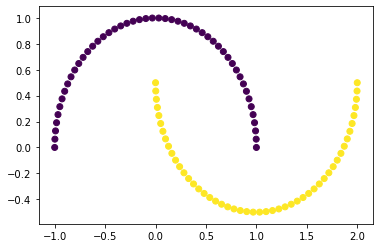

In [8]:
plt.scatter(X_test[:,0], X_test[:,1], c=Y_test)

### Create model and train

In [9]:
embedder = tfUMAP(
    #optimizer=tf.keras.optimizers.Adam(0.01),
    direct_embedding=True,
    verbose=True,
    training_epochs=50,
    negative_sample_rate=5,
)

In [10]:
from tfumap.umap import get_graph_elements

In [11]:
z = embedder.fit_transform(X_train_flat)

tfUMAP(direct_embedding=True, negative_sample_rate=5,
       optimizer=<tensorflow.python.keras.optimizer_v2.adadelta.Adadelta object at 0x7f5bfa5e0a58>,
       tensorboard_logdir='/tmp/tensorboard/20200706-133752',
       training_epochs=50)
Construct fuzzy simplicial set
Mon Jul  6 13:37:53 2020 Finding Nearest Neighbors
Mon Jul  6 13:37:55 2020 Finished Nearest Neighbor Search
Mon Jul  6 13:37:58 2020 Embedding with TensorFlow


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Mon Jul  6 13:38:55 2020 Finished embedding


### Plot model output

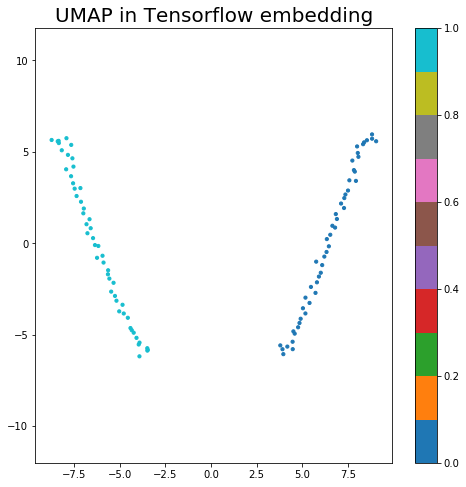

In [12]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=10,
    alpha=1,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### embed test data

In [13]:
z_test = embedder.transform(X_test_flat)

	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs


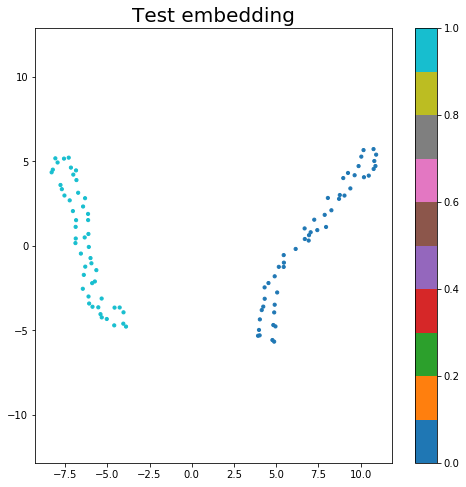

In [14]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z_test[:, 0],
    z_test[:, 1],
    c=Y_test.astype(int)[:len(z)],
    cmap="tab10",
    s=10,
    alpha=1,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("Test embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### View loss

In [15]:
from tfumap.umap import retrieve_tensors
import seaborn as sns

In [16]:
loss_df = retrieve_tensors(embedder.tensorboard_logdir)
loss_df[:3]

['umap_loss']
[]


,wall_time,step,val,group,variable
0,1.594068e+09,1,0.298199,train,umap_loss
1,1.594068e+09,2,0.290236,train,umap_loss
2,1.594068e+09,3,0.314061,train,umap_loss


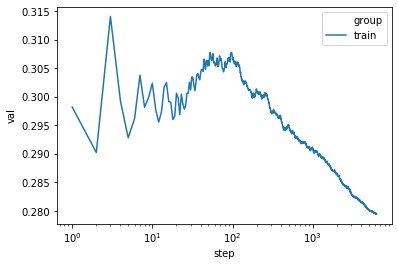

In [17]:
ax = sns.lineplot(x="step", y="val", hue="group", data=loss_df[loss_df.variable=='umap_loss'])
ax.set_xscale('log')

### Compare to direct embedding with base UMAP

In [18]:
from umap import UMAP

In [19]:
z_umap = UMAP(verbose=True).fit_transform(X_train_flat)

UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=True)
Construct fuzzy simplicial set
Mon Jul  6 13:39:02 2020 Finding Nearest Neighbors
Mon Jul  6 13:39:02 2020 Finished Nearest Neighbor Search
Mon Jul  6 13:39:02 2020 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Mon Jul  6 13:39:04 2020 Finished embedding


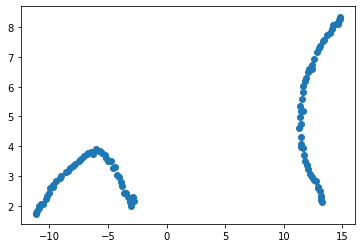

In [20]:
plt.scatter(z_umap[:,0], z_umap[:,1])

In [21]:
### realign using procrustes 
from scipy.spatial import procrustes
z_align, z_umap_align, disparity = procrustes(z, z_umap)
print(disparity)

0.19489770488298896


Text(0.5, 1.0, 'UMAP with UMAP-learn')

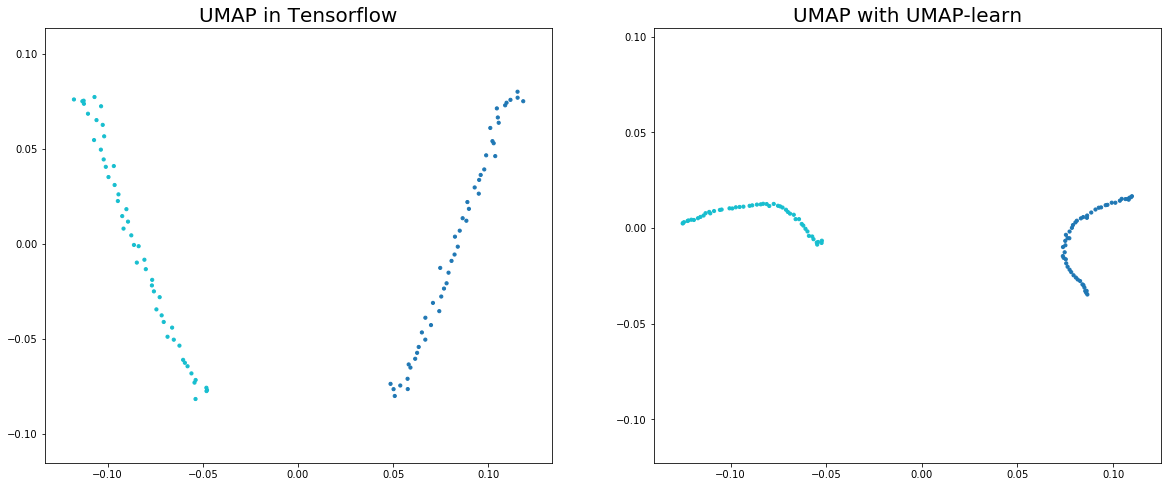

In [22]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 8))
ax = axs[0]
sc = ax.scatter(
    z_align[:, 0],
    z_align[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=10,
    alpha=1,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow", fontsize=20)
#plt.colorbar(sc, ax=ax);

ax = axs[1]
sc = ax.scatter(
    z_umap_align[:, 0],
    z_umap_align[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=10,
    alpha=1,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP with UMAP-learn", fontsize=20)
#plt.colorbar(sc, ax=ax);